# 学習型ISTAによるスパース信号再現

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/ISTA.ipynb)

本アルゴリズムは、TISTA (Ito, Takabe, Wadayama, 2019)

https://ieeexplore.ieee.org/document/8695874

をベースとしています(TISTAそのものではありません)。

問題設定は次のとおり：
* 観測過程は $y = x A^T + w$ とする。
* 観測行列$A$は$m \times n$ 実行列
* $A$の各要素はガウス分布（平均0、分散1）に従う。
* $x$は長さnのスパースベクトルであり、ガウス・ベルヌーイ分布に従う。
* 非ゼロ元の生起確率は$p$であり、非ゼロ要素は平均0、分散1のガウス分布に従う。
* $w$は長さmの雑音ベクトルであり、各要素はガウス分布（平均0, 標準偏差sigma）に従う。

## 必要なパッケージのインポート

In [2]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## グローバル定数の設定

In [3]:
m = 150 # 観測ベクトル次元
n = 300 # 元信号ベクトル次元
sigma = 0.05 # 雑音の標準偏差
mbs   = 20 # ミニバッチサイズ
p     = 0.1 # 元信号の非ゼロ元の生起確率
A = torch.normal(torch.zeros(m, n), std = 1.0) # 観測行列
max_itr = 20 # ISTAの反復回数
adam_lr = 0.0001 # Adamの学習率

## ミニバッチ生成関数
* mbs $\times$ n のミニバッチを返す。ひとつの行がスパースベクトルになっている
* 非ゼロ要素は確率$p$で生起する
* 比ゼロ要素の中身は、平均0, 分散1のガウス分布に従う

In [4]:
def gen_minibatch():
    seq = torch.normal(torch.zeros(mbs, n), 1.0) # ガウス乱数ベクトルの生成
    support = torch.bernoulli(p * torch.ones(mbs, n)) # 非ゼロサポートの生成
    return seq * support # 要素ごとの積(アダマール積)になることに注意

## 学習可能なISTA クラス
* アルゴリズムの詳細の説明は5章にて。
* ２種類の学習可能パラメータが導入されている
* 縮小関数として、ソフトしきい値関数を利用

In [5]:
class ISTA(nn.Module):
    def __init__(self, max_itr):
        super(ISTA, self).__init__()
        self.beta = nn.Parameter(0.001*torch.ones(max_itr)) # 学習可能ステップサイズパラメータ
        self.lam  = nn.Parameter(0.1*torch.ones(max_itr)) # 学習可能縮小パラメータ
    def shrinkage(self, x, lam): # 縮小関数 (ソフトしきい値関数)
        return (x-lam)*(x-lam > 0).float() + (x + lam)*(x+lam < 0).float()
    def forward(self, num_itr):
        s = torch.zeros(mbs, n) # 初期探索点
        for i in range(num_itr):
            r = s + self.beta[i] * (y - s @ A.t()) @ A # @は普通の行列・ベクトル積
            s = self.shrinkage(r, self.lam[i]) 
        return s

## 訓練ループ(インクリメンタルトレーニング）

In [6]:
model = ISTA(max_itr)
opt   = optim.Adam(model.parameters(), lr=adam_lr)
loss_func = nn.MSELoss()
for param in model.named_parameters():
    print(param)
for gen in range(max_itr):
    for i in range(50):
        x = gen_minibatch() # 元信号の生成
        w = torch.normal(torch.zeros(mbs, m), sigma)
        y = torch.mm(x, A.t()) + w # 観測信号の生成
        opt.zero_grad()
        x_hat = model(gen + 1)
        loss  = loss_func(x_hat, x) 
        loss.backward()
        opt.step()
    print(gen, loss.item())

('beta', Parameter containing:
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010], requires_grad=True))
('lam', Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000], requires_grad=True))
0 0.05590994656085968
1 0.047295261174440384
2 0.033993933349847794
3 0.02326088957488537
4 0.016236960887908936
5 0.02013869769871235
6 0.014531373977661133
7 0.011121644638478756
8 0.007115459535270929
9 0.00842995848506689
10 0.00735073909163475
11 0.005499355029314756
12 0.003041329560801387
13 0.003450788324698806
14 0.0023568253964185715
15 0.0015572917181998491
16 0.002252683974802494
17 0.0020952143240720034
18 0.0017694002017378807
19 0.0016618460649624467


## 試験スパース再現

学習の完了したモデルを利用して、スパース信号再現を行い、その結果をプロットする

In [7]:
mbs = 1
with torch.no_grad():
    x = gen_minibatch()
    w = torch.normal(torch.zeros(m), sigma)
    y = torch.mm(x, A.t()) + w
    s = model(max_itr)

## 元信号の表示

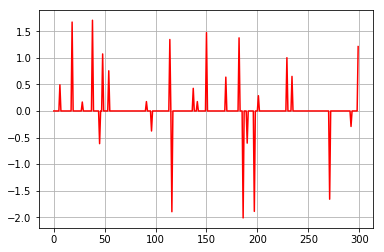

In [8]:
plt.grid()
plt.plot(range(n), x.view(n).cpu().numpy(), color="red")

## 再現信号の表示

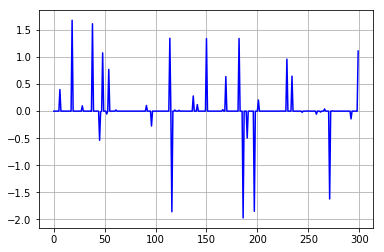

In [9]:
plt.grid()
plt.plot(range(n), s.view(n).detach().numpy(), color="blue")

## 重ねて表示

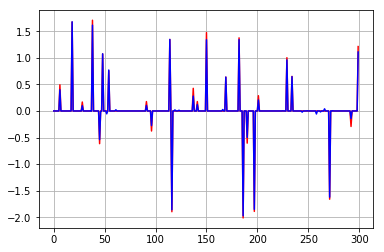

In [10]:
plt.grid()
plt.plot(range(n), x.view(n).detach().numpy(), color="red")
plt.plot(range(n), s.view(n).detach().numpy(), color="blue")

## 学習可能パラメータの表示

In [11]:
print('model.beta = ', model.beta)
print('model.lam = ', model.lam)

model.beta =  Parameter containing:
tensor([ 0.0045,  0.0014,  0.0240,  0.0013,  0.0014,  0.0036,  0.0042,  0.0464,
        -0.0101,  0.0008,  0.0008,  0.0005,  0.0004,  0.0005,  0.0007,  0.0009,
         0.0015,  0.0026,  0.0047,  0.0095], requires_grad=True)
model.lam =  Parameter containing:
tensor([0.1259, 0.1237, 0.1381, 0.1384, 0.1463, 0.1343, 0.1202, 0.0857, 0.0894,
        0.0961, 0.0952, 0.0937, 0.0911, 0.0859, 0.0803, 0.0772, 0.0750, 0.0753,
        0.0772, 0.0841], requires_grad=True)
